<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter11/adversarial_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch_snippets
import torch
import torch.nn as nn

from torch_snippets import show, np
from torch_snippets.inspector import inspect

from torchvision.models import resnet50
model = resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model = model.eval()
import requests
from PIL import Image
url = 'https://lionsvalley.co.za/wp-content/uploads/2015/11/african-elephant-square.jpg'
original_image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
original_image = np.array(original_image)
original_image = torch.Tensor(original_image)

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


C:\Users\hunter\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hunter\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
image_net_classes = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
image_net_classes = requests.get(image_net_classes).text
image_net_ids = eval(image_net_classes)
image_net_classes = {i:j for j,i in image_net_ids.items()}

In [4]:
from torchvision import transforms as T
from torch.nn import functional as F
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalize = T.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])
def image2tensor(input):
    x = normalize(input.clone().permute(2,0,1)/255.)[None]
    return x
def tensor2image(input):
    x = (denormalize(input[0].clone()).permute(1,2,0)*255.).type(torch.uint8)
    return x

In [5]:
def predict_on_image(input):
    model.eval()
    show(input)
    input = image2tensor(input)
    pred = model(input)
    pred = F.softmax(pred, dim=-1)[0]
    prob, clss = torch.max(pred, 0)
    clss = image_net_ids[clss.item()]
    print(f'PREDICTION: `{clss}` @ {prob.item()}')

In [6]:
from tqdm import trange
losses = []
def attack(image, model, target, epsilon=1e-6):
    input = image2tensor(image)
    input.requires_grad = True
    pred = model(input)
    loss = nn.CrossEntropyLoss()(pred, target)
    loss.backward()
    losses.append(loss.mean().item())
    output = input - epsilon * input.grad.sign()
    output = tensor2image(output)
    del input
    return output.detach()

In [7]:
modified_images = []
desired_targets = ['lemon', 'comic book', 'sax, saxophone']

In [8]:
for target in desired_targets:
    target = torch.tensor([image_net_classes[target]])
    image_to_attack = original_image.clone()
    for _ in trange(10):
        image_to_attack = attack(image_to_attack, model, target)
    modified_images.append(image_to_attack)


100%|██████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.86it/s]


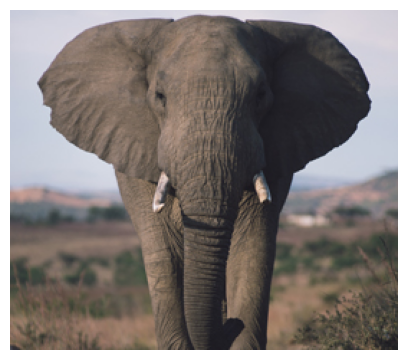

PREDICTION: `African elephant, Loxodonta africana` @ 0.5234397053718567


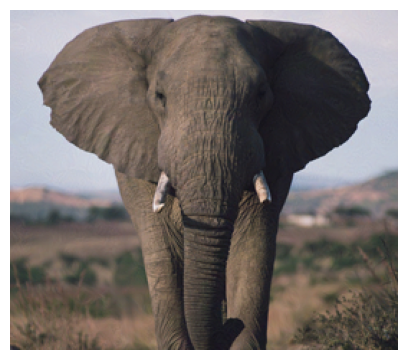

PREDICTION: `lemon` @ 0.9999951124191284


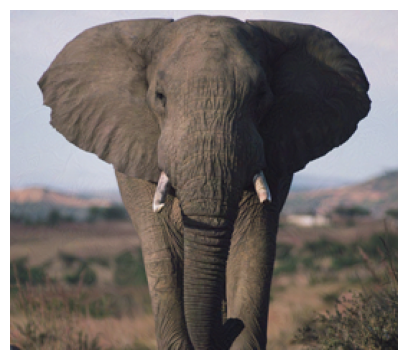

PREDICTION: `comic book` @ 0.9999853372573853


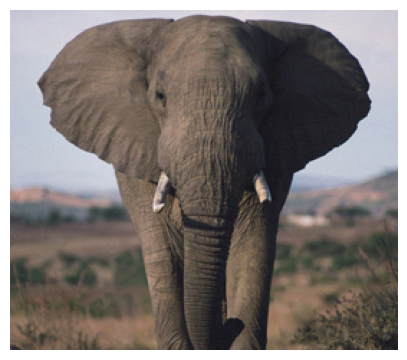

PREDICTION: `sax, saxophone` @ 0.9999995231628418


In [10]:

for image in [original_image, *modified_images]:
    predict_on_image(image)
    #inspect(image)